In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle
import numpy

OUTPUT_IMG_SIZE = [3600, 1800]

PLANET_RADIUS = 260
OM_RAD = 380.53
OM = [None, 
      [0, 0, +OM_RAD], 
      [0, 0, -OM_RAD], 
      [0, +OM_RAD, 0],
      [0, -OM_RAD, 0], 
      [+OM_RAD, 0, 0], 
      [-OM_RAD, 0, 0]]

# Input Image

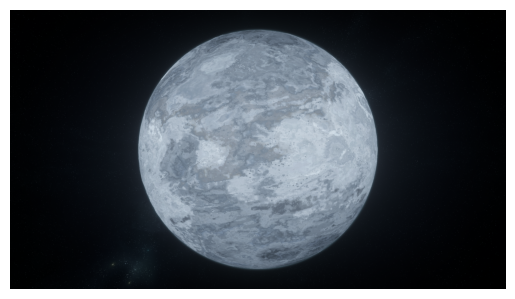

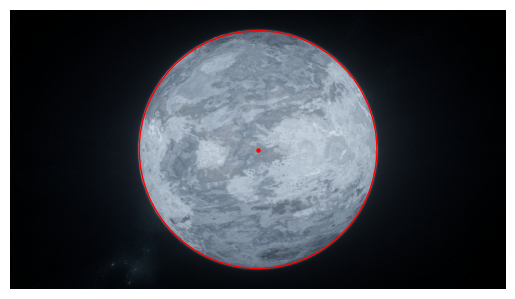

(2160, 3840, 3)


In [2]:
# Read the image
img = mpimg.imread("./images/Cellin448.2_OM1_593.7_3_336.4_6_310.2_fov112.png")
# Hand coded center and radius
center = [1920, 1080]
radius = 920
fov = 112
# img = mpimg.imread("./images/OM4-up2.jpg")
# center = [982, 540]
# radius = 728
# fov = 100

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.scatter(center[0], center[1], color='red', s=5)
plt.gca().add_patch(Circle(center, radius, color="red", fill=False))
# plt.gca().add_patch(Circle(center, radius * 0.7, color="cyan", fill=False))
plt.show()

print(img.shape)

# Empty Output
A coordinate grid with projected OM points

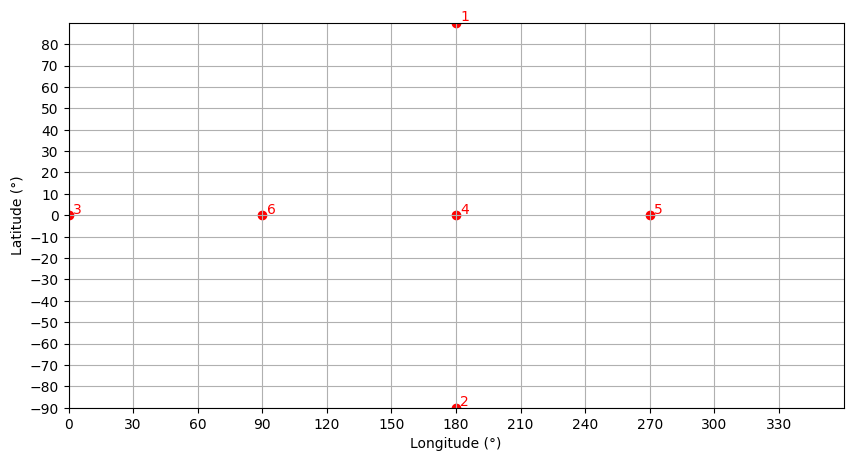

In [3]:
OM_GROUND = numpy.array([[0, 0],
             [180, 90], [180, -90], [0, 0], [180, 0], [270, 0], [90, 0]])
OM_GROUND_LO = OM_GROUND[1:, 0]
OM_GROUND_LA = OM_GROUND[1:, 1]

fig = plt.figure(figsize=(10,5))
plt.xlim(0, 360)
plt.ylim(-90, 90)
ax = fig.gca()

ax.set_xticks(numpy.arange(0, 360, 30))
ax.set_yticks(numpy.arange(-90, 90, 10))
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
plt.grid()
plt.scatter(OM_GROUND_LO, OM_GROUND_LA,c="red")

for i, txt in enumerate(range(1, 7)):
    ax.annotate(txt, (OM_GROUND_LO[i], OM_GROUND_LA[i]), xytext=(OM_GROUND_LO[i] + 2, OM_GROUND_LA[i] + 1), c="red")
    
plt.show()


# Test output
A test map output with desired dimensions.

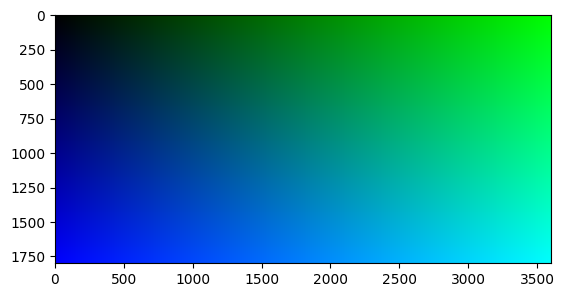

In [4]:
testImg = [[[0, x / OUTPUT_IMG_SIZE[0], y / OUTPUT_IMG_SIZE[1]] for x in range(OUTPUT_IMG_SIZE[0])] for y in range(OUTPUT_IMG_SIZE[1])]

plt.imshow(testImg)


# Quadrilateral location
Compute the camera location with four distances to four known points.

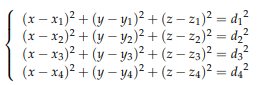

In [5]:
def quadrilateral(x1y1z1, d1, x2y2z2, d2, x3y3z3, d3, x4y4z4, d4):
    x1, y1, z1 = x1y1z1
    x2, y2, z2 = x2y2z2
    x3, y3, z3 = x3y3z3
    x4, y4, z4 = x4y4z4
    A11 = 2 * (x1 - x2)
    A12 = 2 * (y1 - y2)
    A13 = 2 * (z1 - z2)
    A21 = 2 * (x1 - x3)
    A22 = 2 * (y1 - y3)
    A23 = 2 * (z1 - z3)
    A31 = 2 * (x1 - x4)
    A32 = 2 * (y1 - y4)
    A33 = 2 * (z1 - z4)
    temp1 = d1**2 - x1**2 - y1**2 - z1**2
    b1 = d2**2 - x2**2 - y2**2 - z2**2 - temp1
    b2 = d3**2 - x3**2 - y3**2 - z3**2 - temp1
    b3 = d4**2 - x4**2 - y4**2 - z4**2 - temp1
    A = numpy.array([[A11, A12, A13], 
                     [A21, A22, A23], 
                     [A31, A32, A33]])
    b = numpy.array([[b1],
                     [b2],
                     [b3]])
    AInv = numpy.linalg.inv(A)
    result = AInv.dot(b)
    return result[0, 0], result[1, 0], result[2, 0]


Image shot at: 
(-327.78267271962784, 305.52303484613566, -8.926193861193727)


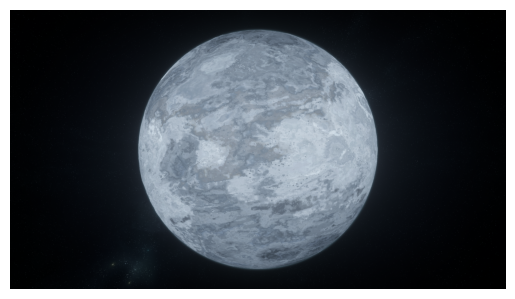

In [6]:
PosTestCamera = quadrilateral([0, 0, 0], 448.2, OM[1], 593.7, OM[3], 336.4, OM[6], 310.2)
print("Image shot at: ")
print(PosTestCamera)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

Put points in model. The test camera location seems correct.

https://www.geogebra.org/calculator/hrqzetby


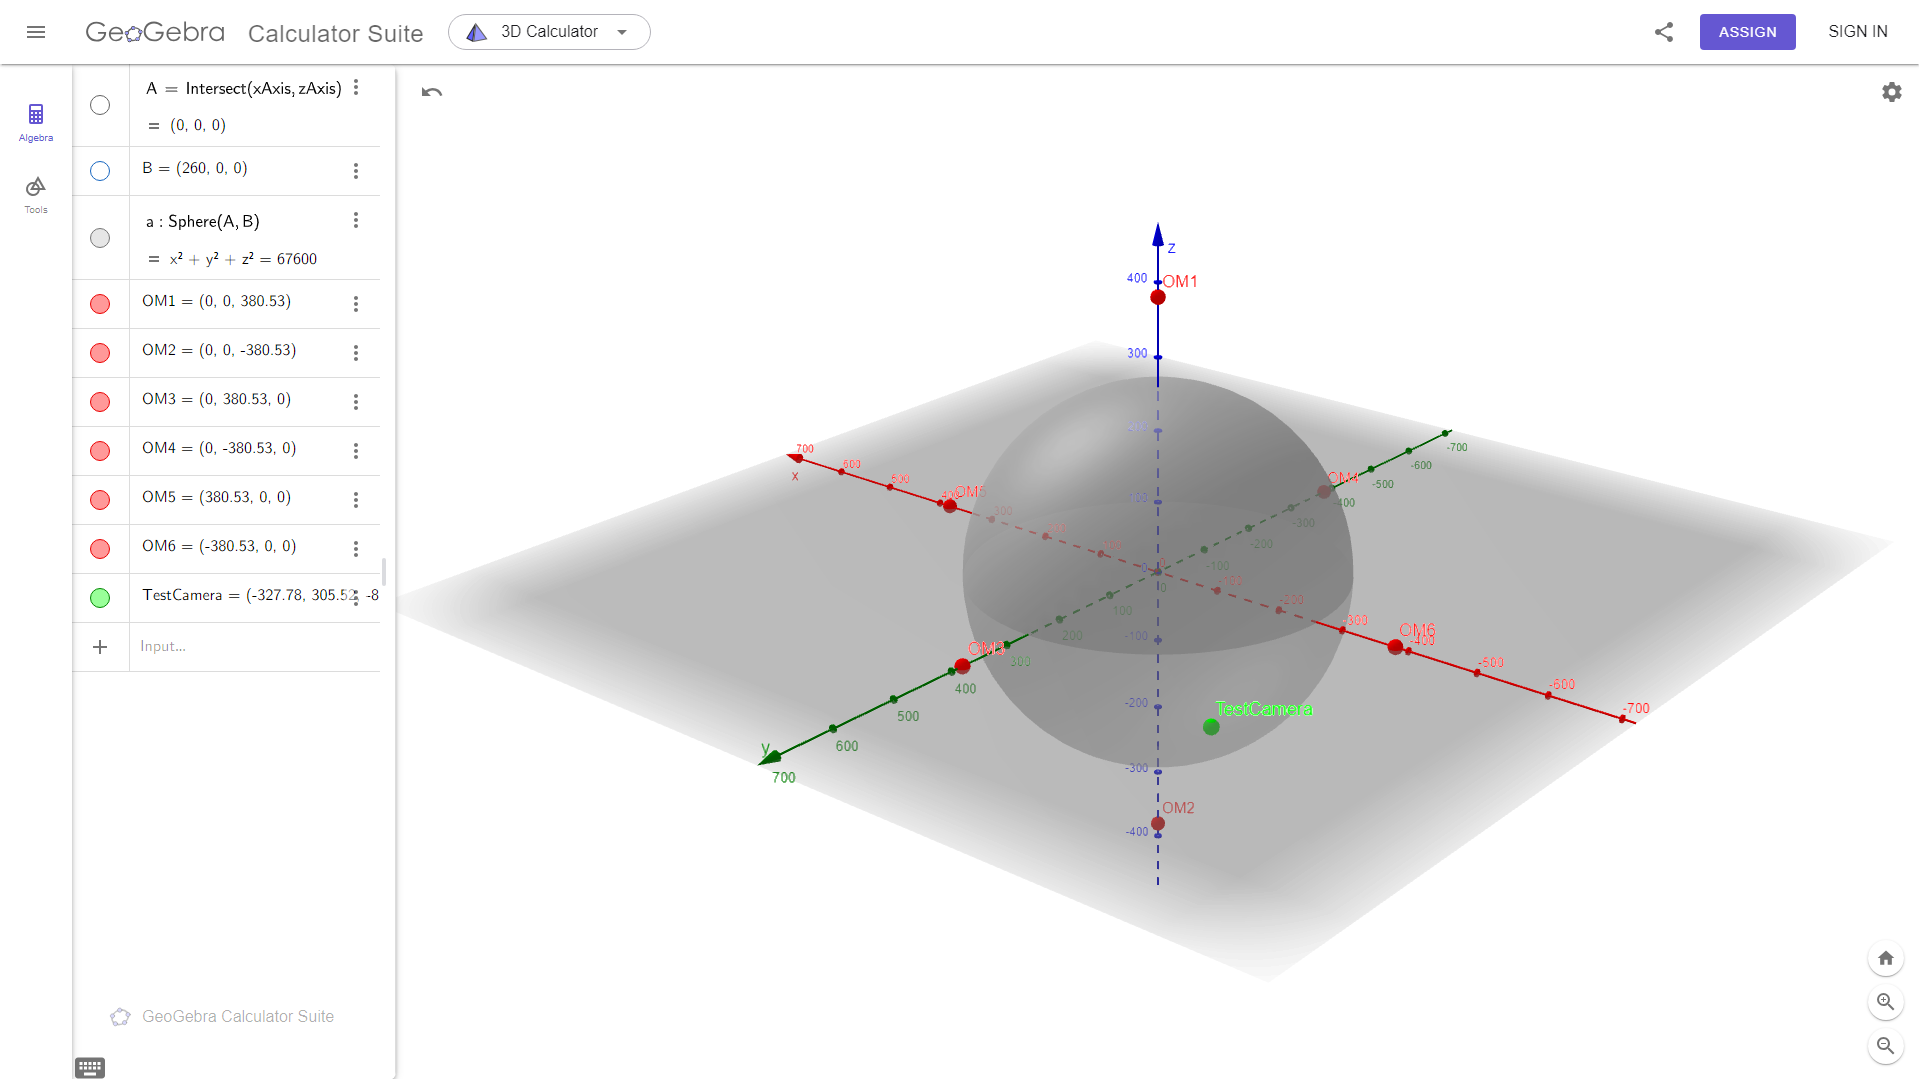

### Project Camera Orbital Position to the ground coordinate system

In [7]:
import math
def projectToGround(orbitalPos):
    x, y, z = orbitalPos
    long = math.atan(-x / y) * 180 / math.pi
    xydis = (x**2 + y**2) ** 0.5
    la = math.atan(z / xydis) * 180 / math.pi
    return long, la

Projected to ground at: 
(47.013022261389104, -1.1412085247938502)


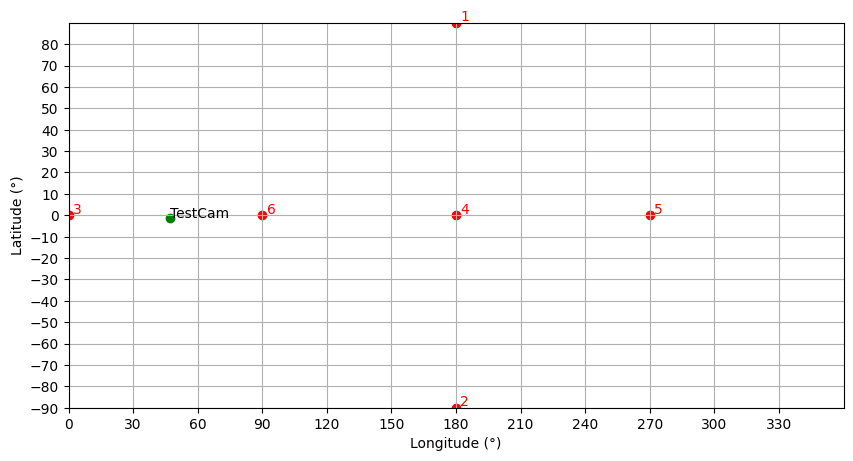

In [8]:
longlaTestCamera = projectToGround(PosTestCamera)
print("Projected to ground at: ")
print(longlaTestCamera)

fig = plt.figure(figsize=(10,5))
plt.xlim(0, 360)
plt.ylim(-90, 90)
ax = fig.gca()

ax.set_xticks(numpy.arange(0, 360, 30))
ax.set_yticks(numpy.arange(-90, 90, 10))
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
plt.grid()
plt.scatter(OM_GROUND_LO, OM_GROUND_LA,c="red")
plt.scatter(longlaTestCamera[0], longlaTestCamera[1], c="green")

for i, txt in enumerate(range(1, 7)):
    ax.annotate(txt, (OM_GROUND_LO[i], OM_GROUND_LA[i]), xytext=(OM_GROUND_LO[i] + 2, OM_GROUND_LA[i] + 1), c="red")
    
ax.annotate("TestCam", (longlaTestCamera[0], longlaTestCamera[1]))
    
plt.show()

# Single Image Projection
Map a single image to the longitude-latitude grid system.

Assume the location and rotation are known.

In [58]:
def longlaToInputImgUV(longla, inputImg, inputFov, inputCenterLongLa, camPos):
    inputUMax = inputImg.shape[1]
    inputVMax = inputImg.shape[0]
    inputCenterU = inputUMax / 2
    inputCenterV = inputVMax / 2
    inputCenterLong = inputCenterLongLa[0]
    inputCenterLati = inputCenterLongLa[1]
    localLong = longla[0] - inputCenterLong
    localLati = longla[1] - inputCenterLati
    # Calculate x, y, z from localLong and localLati relatives to camera's coordspace: 
    # x: image plane x, 
    # y: image plane y, 
    # z: image normal, centered at planet's center, towards the image
    localX = PLANET_RADIUS * math.cos(localLati * math.pi / 180) * math.sin(localLong * math.pi / 180)
    localZ = PLANET_RADIUS * math.cos(localLati * math.pi / 180) * math.cos(localLong * math.pi / 180)
    localY = PLANET_RADIUS * math.sin(localLati * math.pi / 180)
    
    focal = inputUMax / 2 / math.tan(inputFov / 2 * math.pi / 180)
    
    imgU = inputCenterU + focal / (abs(numpy.linalg.norm(camPos)) - localZ) * localX
    imgV = inputCenterV + focal / (abs(numpy.linalg.norm(camPos)) - localZ) * localY
    return round(imgU), round(imgV)

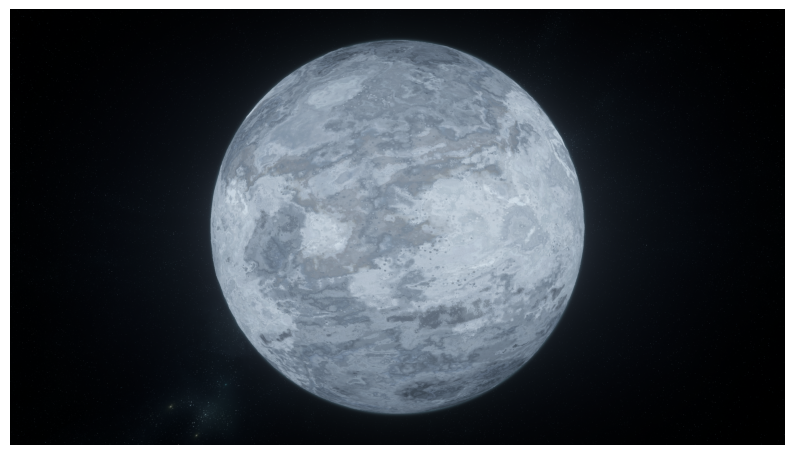

In [59]:
plt.figure(figsize=(10, 20))     
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

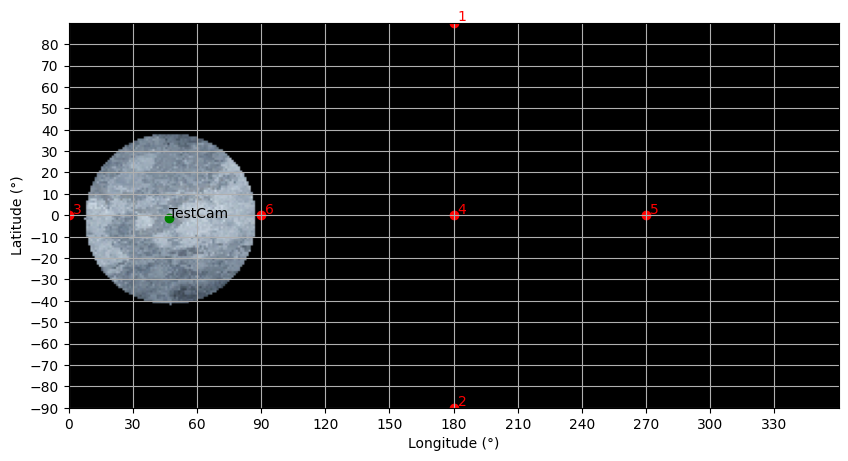

In [61]:
testMap = numpy.zeros((180, 360, 3))
useRadius = 40 # unit: degree, pixels in this radius are used
for lo in range(int(longlaTestCamera[0]) - useRadius, int(longlaTestCamera[0]) + useRadius):
    for la in range(int(longlaTestCamera[1]) - useRadius, int(longlaTestCamera[1]) + useRadius):
        if (numpy.linalg.norm([lo - int(longlaTestCamera[0]), la - int(longlaTestCamera[1])]) > useRadius): continue
        u, v = longlaToInputImgUV([lo, la], img, fov, longlaTestCamera, PosTestCamera)
        testMap[90-la, lo] = img[-v, u]

fig = plt.figure(figsize=(10,5))
plt.xlim(0, 360)
plt.ylim(-90, 90)
ax = fig.gca()

ax.set_xticks(numpy.arange(0, 360, 30))
ax.set_yticks(numpy.arange(-90, 90, 10))
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
plt.grid()
plt.scatter(OM_GROUND_LO, OM_GROUND_LA,c="red")
plt.scatter(longlaTestCamera[0], longlaTestCamera[1], c="green")

for i, txt in enumerate(range(1, 7)):
    ax.annotate(txt, (OM_GROUND_LO[i], OM_GROUND_LA[i]), xytext=(OM_GROUND_LO[i] + 2, OM_GROUND_LA[i] + 1), c="red")
    
ax.annotate("TestCam", (longlaTestCamera[0], longlaTestCamera[1]))  

plt.imshow(testMap, extent = [0, 360, -90, 90])
plt.show()

# Multi Image Projection
Using method "Structure from motion".

https://en.wikipedia.org/wiki/Structure_from_motion

Possible application for reference: https://www.capturingreality.com/realitycapture-13